
__References:__ 

[Faster R-CNN (object detection) implemented by Keras for custom data from Google’s Open Images Dataset V4](https://towardsdatascience.com/faster-r-cnn-object-detection-implemented-by-keras-for-custom-data-from-googles-open-images-125f62b9141a)

https://github.com/RockyXu66/Faster_RCNN_for_Open_Images_Dataset_Keras

# Install Libs

In [1]:
!pip install --upgrade pyDSlib
!pip install wget
import IPython
IPython.display.clear_output()

# Import Libs

In [34]:
import tensorflow as tf
import sys, os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import wget
import skimage
import cv2
import joblib
import shutil
import gc

In [2]:
gc.collect()

31

In [3]:
sys.path.insert(0, '/mr3_boltprod_john_t_leonard/Data_Science_Projects./ObjDetection/pyDSlib/')

In [4]:
import pyDSlib as DS
DS.__version__

pycocotools is not installed. To use pretrained mask-RCNN on coco, run $pip install pycocotools


'0.3.5'

# Define Paths

In [5]:
root_dir = os.path.abspath('../../../')
data_dir = os.path.join(root_dir, 'ObjDetection_Data')
outputs_dir = os.path.join(root_dir,'outputs')

for dir_ in [data_dir, outputs_dir]:
    if not os.path.isdir(dir_):
        os.makedirs(dir_)

# Fetch Dataset

We'll use google's open images dataset. This dataset contains 600 classes. We'll pull the meta data for everything, then only pull the images for a single class.

__References:__

https://storage.googleapis.com/openimages/web/download.html

https://www.figure-eight.com/dataset/open-images-annotated-with-bounding-boxes/

## Fetch Meta Data

In [6]:
data_dir = os.path.join(data_dir,'open_images_v5')
imgs_dir = os.path.join(data_dir, 'imgs')

for dir_ in [data_dir, imgs_dir]:
    if not os.path.isdir(dir_):
        os.makedirs(dir_)

In [7]:
downloads = {'class-descriptions-boxable.csv':'https://storage.googleapis.com/openimages/v5/class-descriptions-boxable.csv',
             'train-annotations-bbox.csv': 'https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-annotations-bbox.csv',
             'train-images-boxable.csv': 'https://datasets.figure-eight.com/figure_eight_datasets/open-images/train-images-boxable.csv'}

In [8]:
for key in downloads.keys():
    file = os.path.join(data_dir, key)
    if not os.path.isfile(file):
        wget.download(downloads[key], file)

In [9]:
os.listdir(data_dir)

['imgs',
 'class-descriptions-boxable.csv',
 'train-images-boxable.csv',
 'train-annotations-bbox.csv']

In [10]:
class_descriptions = pd.read_csv(os.path.join(data_dir, 'class-descriptions-boxable.csv'),
                                 header = None)
class_descriptions.columns = ['LabelName', 'class']
imgs_boxable = pd.read_csv(os.path.join(data_dir, 'train-images-boxable.csv'))
annotations_bbox = pd.read_csv(os.path.join(data_dir, 'train-annotations-bbox.csv'))

In [11]:
class_descriptions.head()

LabelName       class
0    /m/011k07    Tortoise
1  /m/011q46kg   Container
2    /m/012074      Magpie
3    /m/0120dh  Sea turtle
4    /m/01226z    Football

In [12]:
imgs_boxable['ImageID'] = imgs_boxable['image_name'].str.split('.',expand=True).iloc[:,0]
imgs_boxable.head()

image_name                                          image_url  \
0  e39871fd9fd74f55.jpg  https://requestor-proxy.figure-eight.com/figur...   
1  f18b91585c4d3f3e.jpg  https://requestor-proxy.figure-eight.com/figur...   
2  ede6e66b2fb59aab.jpg  https://requestor-proxy.figure-eight.com/figur...   
3  ed600d57fcee4f94.jpg  https://requestor-proxy.figure-eight.com/figur...   
4  ff47e649b23f446d.jpg  https://requestor-proxy.figure-eight.com/figur...   

            ImageID  
0  e39871fd9fd74f55  
1  f18b91585c4d3f3e  
2  ede6e66b2fb59aab  
3  ed600d57fcee4f94  
4  ff47e649b23f446d

In [13]:
annotations_bbox.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside  
0         0  
1         0  
2         0  
3         0  
4         0

In [14]:
annotations_bbox.shape

(14610229, 13)

## Merge all meta data

In [15]:
img_meta = pd.merge(annotations_bbox, imgs_boxable, on = 'ImageID')
img_meta = pd.merge(img_meta, class_descriptions, on = 'LabelName')
img_meta.shape

(14610229, 16)

## Initial Image Inspection

In [16]:
def plot_img(ImageID, 
             img_meta,
             tight_layout_rect=(0,0,1,1)):
    """
    show an image and the bounding boxes for that image given an ImageID
    """
    
    # fetch image
    img_name = ImageID+'.jpg'
    img_url = img_meta[img_meta['image_name']==img_name]['image_url'].iloc[0]
    img = skimage.io.imread(img_url)
    height, width, _ = img.shape
    
    #fetch bbox's and annotations
    img_meta = img_meta[img_meta['ImageID']==ImageID]
    
    fig, ax = plt.subplots(1,1)
    
    ax.set_title('ImageID:'+ImageID)
    
    #add bbox's and annotations to img
    for i, slice_ in img_meta.iterrows():
        
        #build box
        xymin = (int(slice_['XMin']*width), 
                 int(slice_['YMin']*height))
        xymax = (int(slice_['XMax']*width), 
                 int(slice_['YMax']*height))
        cv2.rectangle(img, xymin, xymax, (0,255,0), 2)
        
        #build annotation
        label_name = slice_['LabelName']
        class_series = img_meta[img_meta['LabelName']==label_name]
        class_name = class_series['class'].iloc[0]
        cv2.putText(img, class_name, 
                    (xymin[0]+5,xymin[1]+20),
                    cv2.FONT_HERSHEY_SIMPLEX,
                    1, (0,255,0), 2)
    
    #plot img
    ax.imshow(img)
    ax.grid(which='both',visible=False)
    
    fig.tight_layout(rect=tight_layout_rect)
    plt.show()

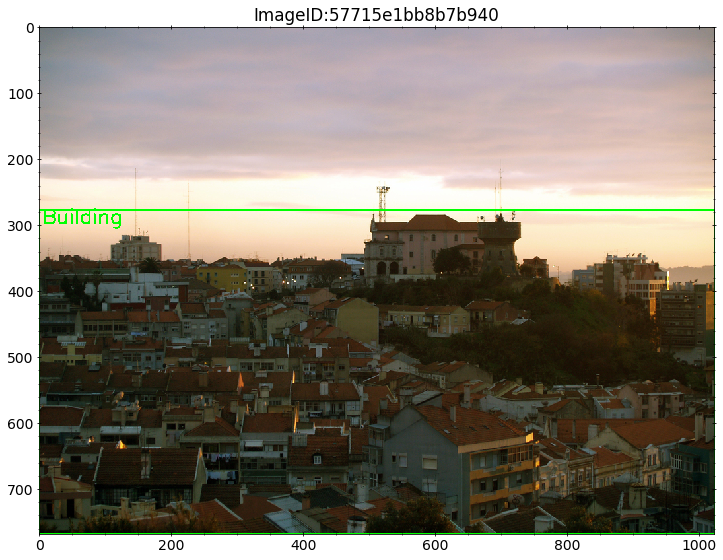

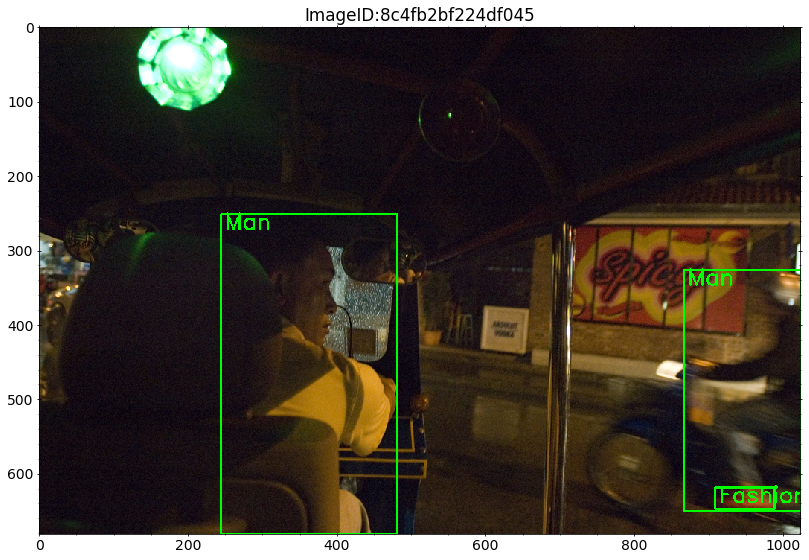

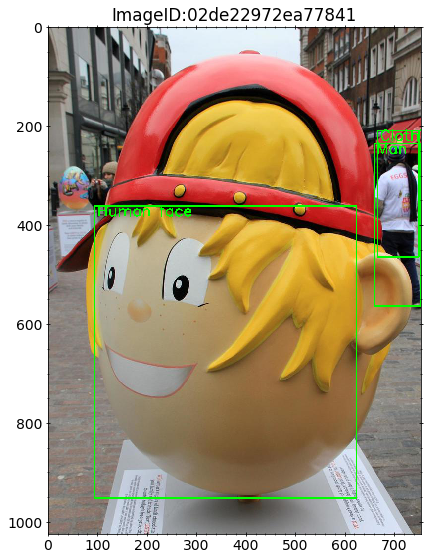

In [17]:
ImageIDs = img_meta['ImageID'].unique()
for i in list(np.random.randint(0,len(ImageIDs)-1, 3)):
    
    ImageID=ImageIDs[i]
    
    plot_img(ImageID, 
         img_meta,
         tight_layout_rect=(0,0,2,2))

# Inspect Classes

In [18]:
classes = sorted(list(img_meta['class'].unique()))
print('n classes', len(classes))
display(classes)

n classes 599


['Accordion',
 'Adhesive tape',
 'Aircraft',
 'Airplane',
 'Alarm clock',
 'Alpaca',
 'Ambulance',
 'Animal',
 'Ant',
 'Antelope',
 'Apple',
 'Armadillo',
 'Artichoke',
 'Auto part',
 'Axe',
 'Backpack',
 'Bagel',
 'Baked goods',
 'Balance beam',
 'Ball',
 'Balloon',
 'Banana',
 'Band-aid',
 'Banjo',
 'Barge',
 'Barrel',
 'Baseball bat',
 'Baseball glove',
 'Bat (Animal)',
 'Bathroom accessory',
 'Bathroom cabinet',
 'Bathtub',
 'Beaker',
 'Bear',
 'Bed',
 'Bee',
 'Beehive',
 'Beer',
 'Beetle',
 'Bell pepper',
 'Belt',
 'Bench',
 'Bicycle',
 'Bicycle helmet',
 'Bicycle wheel',
 'Bidet',
 'Billboard',
 'Billiard table',
 'Binoculars',
 'Bird',
 'Blender',
 'Blue jay',
 'Boat',
 'Bomb',
 'Book',
 'Bookcase',
 'Boot',
 'Bottle',
 'Bottle opener',
 'Bow and arrow',
 'Bowl',
 'Bowling equipment',
 'Box',
 'Boy',
 'Brassiere',
 'Bread',
 'Briefcase',
 'Broccoli',
 'Bronze sculpture',
 'Brown bear',
 'Building',
 'Bull',
 'Burrito',
 'Bus',
 'Bust',
 'Butterfly',
 'Cabbage',
 'Cabinetry',
 'C

# Fetch Subset of Images

Let's just focus on detecting people

In [19]:
classes =['Backpack', 
         'Belt', 
         'Bicycle helmet', 
         'Person', 
         'Binoculars', 
         'Boot', 
         'Briefcase',
         'Calculator',
         'Camera',
         'Clothing',
         'Coat',
         'Computer keyboard',
         'Computer monitor',
         'Computer mouse',
         'Cowboy hat',
         'Crown',
         'Dog',
         'Doll',
         'Dress',
         'Earrings',
         'Fashion accessory',
         'Fedora',
         'Flag',
         'Flower',
         'Footwear',
         'Girl',
         'Glasses',
         'Glove',
         'Goggles',
         'Handbag',
         'Hat',
         'Headphones',
         'High heels',
         'Hiking equipment',
         'Human arm',
         'Human beard',
         'Human body',
         'Human ear',
         'Human eye',
         'Human face',
         'Human foot',
         'Human hair',
         'Human hand',
         'Human head',
         'Human leg',
         'Human mouth',
         'Human nose',
         'Ipod',
         'Jacket',
         'Laptop',
         'Lipstick',
         'Luggage and bags',
         'Man',
         'Necklace',
         'Person',
         'Roller skates',
         'Shirt',
         'Shorts',
         'Skateboard',
         'Ski',
         'Skirt',
         'Sock',
         'Sombrero',
         'Sports equipment',
         'Sports uniform',
         'Suit',
         'Suitcase',
         'Sun hat',
         'Sunglasses',
         'Swimwear',
         'Tablet computer',
         'Teddy bear',
         'Telephone',
         'Television',
         'Tennis racket',
         'Tie',
         'Toy',
         'Training bench',
         'Tree',
         'Watch',
         'Wheelchair',
         'Window',
         'Window blind',
         'Woman',
          ]

img_meta = img_meta[img_meta['class'].isin(classes)]
img_meta.shape

(10462676, 16)

In [20]:
ImageIDs = list(img_meta['ImageID'].unique())
ImageNames = [ImageID + '.jpg' for ImageID in ImageIDs]
print('n images:',len(ImageIDs))

n images: 1196044


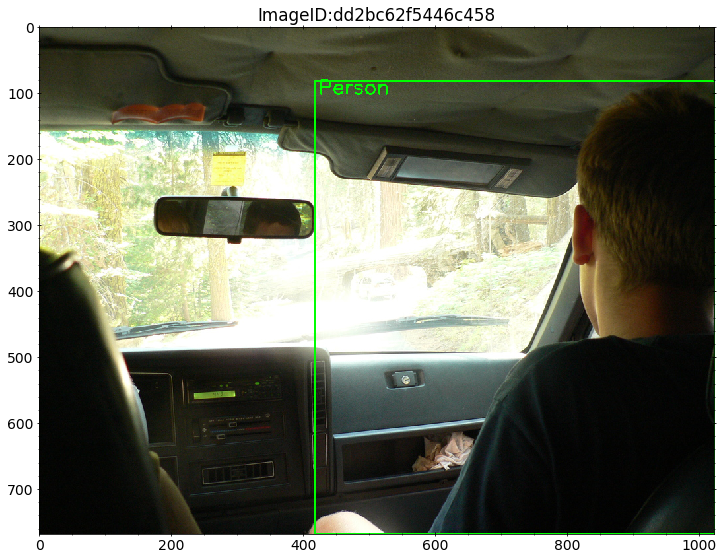

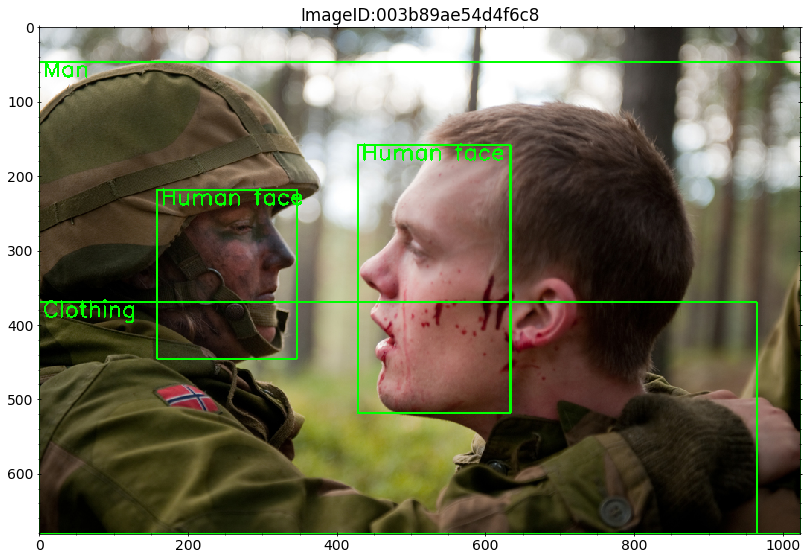

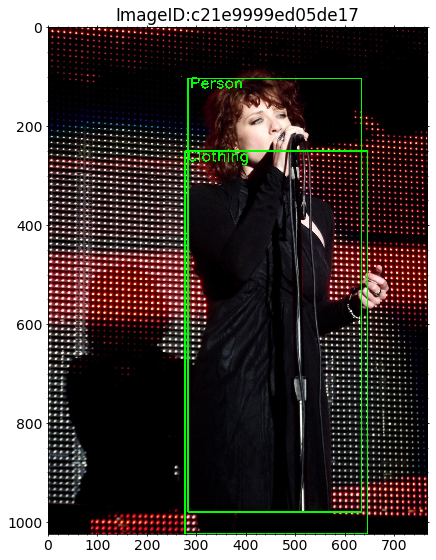

In [21]:
for i in list(np.random.randint(0,len(ImageIDs)-1, 3)):
    
    ImageID=ImageIDs[i]
    
    plot_img(ImageID, 
         img_meta,
         tight_layout_rect=(0,0,2,2))

### Setup Flow From Generator Directories

In [22]:
import sklearn.model_selection

In [23]:
# #slice out subsample
# subsample_size=len(ImageNames)
# ImageNames = ImageNames[0:subsample_size]

In [24]:
#train test split ImageNames
ImageNames_train, ImageNames_test = sklearn.model_selection.train_test_split(
                                                             ImageNames, 
                                                             test_size = 0.2, 
                                                             random_state = 0)

In [25]:
print('n train images:', len(ImageNames_train))
print('n test images:',len(ImageNames_test))

n train images: 956835
n test images: 239209


In [26]:
img_meta.head()

ImageID  Source  LabelName  Confidence      XMin      XMax  \
0  000002b66c9c498e  xclick  /m/01g317           1  0.012500  0.195312   
1  000002b66c9c498e  xclick  /m/01g317           1  0.025000  0.276563   
2  000002b66c9c498e  xclick  /m/01g317           1  0.151562  0.310937   
3  000002b66c9c498e  xclick  /m/01g317           1  0.256250  0.429688   
4  000002b66c9c498e  xclick  /m/01g317           1  0.257812  0.346875   

       YMin      YMax  IsOccluded  IsTruncated  IsGroupOf  IsDepiction  \
0  0.148438  0.587500           0            1          0            0   
1  0.714063  0.948438           0            1          0            0   
2  0.198437  0.590625           1            0          0            0   
3  0.651563  0.925000           1            0          0            0   
4  0.235938  0.385938           1            0          0            0   

   IsInside            image_name  \
0         0  000002b66c9c498e.jpg   
1         0  000002b66c9c498e.jpg   
2         0  000002b66c9c498e.jpg   
3         0  000002b66c9c498e.jpg   
4         0  000002b66c9c498e.jpg   

                                           image_url   class  
0  https://requestor-proxy.figure-eight.com/figur...  Person  
1  https://requestor-proxy.figure-eight.com/figur...  Person  
2  https://requestor-proxy.figure-eight.com/figur...  Person  
3  https://requestor-proxy.figure-eight.com/figur...  Person  
4  https://requestor-proxy.figure-eight.com/figur...  Person

In [28]:
img_meta = img_meta.sort_values('class')

In [29]:
print(imgs_dir)

/mr3_boltprod_john_t_leonard/Data_Science_Projects./ObjDetection/pyDSlib/ObjDetection_Data/open_images_v5/imgs


In [30]:
os.listdir(imgs_dir)

['train']

In [50]:
def download_img(ImageName, img_url, imgs_dir, df_by_ImageName, ImageNames_train):
    
    #assign image to train test set directories
    if ImageName in ImageNames_train:
        imgs_dir_train_test = os.path.join(imgs_dir, 'train')
    else:
        imgs_dir_train_test = os.path.join(imgs_dir, 'test')
    
    #build paths and directory for each image
    img_paths = [os.path.join(imgs_dir_train_test, class_, ImageName) for class_ in df_by_ImageName['class'].unique()]
    for img_path in img_paths:
        img_dir=os.path.split(img_path)[0]
        if not os.path.isdir(img_dir):
            os.makedirs(img_dir)
    
    #download and copy images to each class directory
    img_path0 = img_paths[0]
    if not os.path.isfile(img_path0):
        wget.download(img_url, img_path0)
    for img_path in img_paths[1:]:
        if not os.path.isfile(img_path):
            shutil.copyfile(img_path0, img_path)
            
    #collect garbage
    [gc.collect() for i in range(3)]
    

def download_imgs(img_meta, imgs_dir, ImageNames_train, verbose = 2):

    print('n Images to download:',len(img_meta['image_name'].unique()))
    executor = joblib.Parallel(n_jobs=-1, verbose = 2, backend='multiprocessing' )
    jobs = [joblib.delayed(download_img)(ImageName, img_url, imgs_dir, df_by_ImageName, ImageNames_train) for [ImageName, img_url], df_by_ImageName in img_meta.groupby(['image_name','image_url'])]
    executor(jobs)
    

In [ ]:
download_imgs(img_meta, imgs_dir, ImageNames_train, verbose = 5)

n Images to download: 1196044


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:  7.4min
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed: 13.3min
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed: 21.6min
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed: 31.8min
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed: 44.0min
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed: 58.0min
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed: 74.2min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed: 92.0min


In [ ]:
def download_img(ImageName, imgs_dir, img_url):
    path_img = os.path.join(imgs_dir, ImageName)

    if not os.path.isfile(path_img):
        wget.download(img_url, path_img)
        
def download_imgs(img_meta, imgs_dir):

    if not os.path.isdir(imgs_dir):
        os.makedirs(imgs_dir)
    
    #Instantiate parallel job   
    print('n Images to download:',len(img_meta['image_name'].unique()))
    executor = joblib.Parallel(n_jobs=-1, verbose = 2, backend='multiprocessing' )
    jobs = [joblib.delayed(download_img)(ImageName, imgs_dir, img_url) for [ImageName, img_url], _ in img_meta.groupby(['image_name','image_url'])]
    outputs = executor(jobs)
    gc.collect()

In [31]:
for [class_, LabelName], img_meta_by_class in img_meta.groupby(['class', 'LabelName']):
    
    print(class_)
    
    img_meta_by_class_train = img_meta_by_class[img_meta_by_class['image_name'].isin(ImageNames_train)]
    img_meta_by_class_test = img_meta_by_class[img_meta_by_class['image_name'].isin(ImageNames_test)]
    
    imgs_dir_train = os.path.join(imgs_dir, 'train', class_)
    imgs_dir_test = os.path.join(imgs_dir, 'test', class_)
    
    Complete=False
    while not Complete:
        try:
            download_imgs(img_meta_by_class_train, imgs_dir_train)
            download_imgs(img_meta_by_class_test, imgs_dir_test) 
            Complete=True
        except Exception as e:
            print(e)

Backpack
n Images to download: 582


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 582 out of 582 | elapsed:   12.1s finished


n Images to download: 133


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    3.0s finished


Belt
n Images to download: 281


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 281 out of 281 | elapsed:    5.8s finished


n Images to download: 67


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  42 out of  67 | elapsed:    1.1s remaining:    0.7s
[Parallel(n_jobs=-1)]: Done  67 out of  67 | elapsed:    1.7s finished


Bicycle helmet
n Images to download: 3966


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.6s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3966 out of 3966 | elapsed:  1.4min finished


n Images to download: 1040


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1040 out of 1040 | elapsed:   21.2s finished


Binoculars
n Images to download: 91


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  78 out of  91 | elapsed:    1.9s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  91 out of  91 | elapsed:    2.1s finished


n Images to download: 18


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   9 out of  18 | elapsed:    0.6s remaining:    0.6s
[Parallel(n_jobs=-1)]: Done  18 out of  18 | elapsed:    0.7s finished


Boot
n Images to download: 1130


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1130 out of 1130 | elapsed:   22.6s finished


n Images to download: 296


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 296 out of 296 | elapsed:    6.1s finished


Briefcase
n Images to download: 95


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  84 out of  95 | elapsed:    1.9s remaining:    0.2s
[Parallel(n_jobs=-1)]: Done  95 out of  95 | elapsed:    2.3s finished


n Images to download: 16


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done   2 out of  16 | elapsed:    0.5s remaining:    3.3s
[Parallel(n_jobs=-1)]: Done  11 out of  16 | elapsed:    0.7s remaining:    0.3s
[Parallel(n_jobs=-1)]: Done  16 out of  16 | elapsed:    0.7s finished


Calculator
n Images to download: 137


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 137 out of 137 | elapsed:    3.0s finished


n Images to download: 35


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done  12 out of  35 | elapsed:    0.6s remaining:    1.1s
[Parallel(n_jobs=-1)]: Done  30 out of  35 | elapsed:    0.7s remaining:    0.1s
[Parallel(n_jobs=-1)]: Done  35 out of  35 | elapsed:    1.1s finished


Camera
n Images to download: 3991


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.2s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3991 out of 3991 | elapsed:  1.3min finished


n Images to download: 1046


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1046 out of 1046 | elapsed:   21.0s finished


Clothing
n Images to download: 262389


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 65429


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.0s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

Coat
n Images to download: 2797


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.0s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 2797 out of 2797 | elapsed:   57.1s finished


n Images to download: 719


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 719 out of 719 | elapsed:   14.8s finished


Computer keyboard
n Images to download: 2661


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.3s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   49.5s
[Parallel(n_jobs=-1)]: Done 2661 out of 2661 | elapsed:   51.9s finished


n Images to download: 670


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 670 out of 670 | elapsed:   13.3s finished


Computer monitor
n Images to download: 2684


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.2s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.3s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   48.9s
[Parallel(n_jobs=-1)]: Done 2684 out of 2684 | elapsed:   51.9s finished


n Images to download: 655


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 655 out of 655 | elapsed:   13.0s finished


Computer mouse
n Images to download: 497


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.0s
[Parallel(n_jobs=-1)]: Done 497 out of 497 | elapsed:    9.6s finished


n Images to download: 125


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 125 out of 125 | elapsed:    2.8s finished


Cowboy hat
n Images to download: 1579


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.3s
[Parallel(n_jobs=-1)]: Done 1579 out of 1579 | elapsed:   32.0s finished


n Images to download: 398


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 398 out of 398 | elapsed:    8.3s finished


Crown
n Images to download: 431


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 431 out of 431 | elapsed:    9.0s finished


n Images to download: 123


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 123 out of 123 | elapsed:    2.8s finished


Dog
n Images to download: 16607


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.5s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.5s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 4000


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 4000 out of 4000 | elapsed:  1.4min finished


Doll
n Images to download: 2744


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 2744 out of 2744 | elapsed:   55.0s finished


n Images to download: 639


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 639 out of 639 | elapsed:   13.1s finished


Dress
n Images to download: 25163


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.2s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

Error sending result: '<multiprocessing.pool.ExceptionWithTraceback object at 0x7fd04ca1ee10>'. Reason: 'TypeError("cannot serialize '_io.BufferedReader' object")'
n Images to download: 25163


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 144 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 2020 tasks      | elapsed:    0.1s
[Parallel(n_jobs=-1)]: Done 21783 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 25163 out of 25163 | elapsed:  3.9min finished


n Images to download: 6364


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.5s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.1s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.4s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6364 out of 6364 | elapsed:  2.2min finished


Earrings
n Images to download: 536


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 536 out of 536 | elapsed:   10.6s finished


n Images to download: 133


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 133 out of 133 | elapsed:    3.0s finished


Fashion accessory
n Images to download: 18351


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.7s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

Fedora
n Images to download: 2338


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.5s
[Parallel(n_jobs=-1)]: Done 2338 out of 2338 | elapsed:   46.8s finished


n Images to download: 572


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 572 out of 572 | elapsed:   11.7s finished


Flag
n Images to download: 6757


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.9s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.9s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6757 out of 6757 | elapsed:  2.3min finished


n Images to download: 1645


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.2s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.6s
[Parallel(n_jobs=-1)]: Done 1645 out of 1645 | elapsed:   33.6s finished


Flower
n Images to download: 50338


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.8s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 12378


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.4s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10308 

Footwear
n Images to download: 104756


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.6s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.9s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   29.0s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   52.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 25967


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.3s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.8s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.8s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   39.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   52.2s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.4min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.7min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  2.0min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.7min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.1min
[Parallel(n_jobs=-1)]: Done 10308 

Girl
n Images to download: 75108


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.4s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.8s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   51.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 18623


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.1s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.2s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.7s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.8s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

Glasses
n Images to download: 33587


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 8358


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.9s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.2s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8358 out of 8358 | elapsed:  2.8min finished


Glove
n Images to download: 569


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 569 out of 569 | elapsed:   11.7s finished


n Images to download: 164


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 164 out of 164 | elapsed:    3.7s finished


Goggles
n Images to download: 5662


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.5s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.0s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   49.8s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5662 out of 5662 | elapsed:  1.8min finished


n Images to download: 1466


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1466 out of 1466 | elapsed:   29.1s finished


Handbag
n Images to download: 1551


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.1s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.0s
[Parallel(n_jobs=-1)]: Done 1551 out of 1551 | elapsed:   31.1s finished


n Images to download: 350


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 350 out of 350 | elapsed:    7.2s finished


Hat
n Images to download: 6726


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.5s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6726 out of 6726 | elapsed:  2.2min finished


n Images to download: 1734


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.3s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1734 out of 1734 | elapsed:   35.1s finished


Headphones
n Images to download: 856


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 856 out of 856 | elapsed:   16.9s finished


n Images to download: 208


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 208 out of 208 | elapsed:    4.4s finished


High heels
n Images to download: 1228


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.5s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.7s
[Parallel(n_jobs=-1)]: Done 1228 out of 1228 | elapsed:   24.0s finished


n Images to download: 304


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 304 out of 304 | elapsed:    6.1s finished


Hiking equipment
n Images to download: 2061


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.6s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   20.2s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   29.5s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   40.5s
[Parallel(n_jobs=-1)]: Done 2061 out of 2061 | elapsed:   43.4s finished


n Images to download: 510


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.7s
[Parallel(n_jobs=-1)]: Done 510 out of 510 | elapsed:   10.9s finished


Human arm
n Images to download: 32993


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   12.0s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   28.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.6s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.6s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.3min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 8387


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.9s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.1s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 8387 out of 8387 | elapsed:  2.8min finished


Human beard
n Images to download: 2220


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 2220 out of 2220 | elapsed:   43.6s finished


n Images to download: 551


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 551 out of 551 | elapsed:   11.0s finished


Human body
n Images to download: 36281


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.2s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.8s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.4s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.3s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 9117


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.7s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.5s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.8s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   49.7s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 9117 o

Human ear
n Images to download: 6588


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.2s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.4s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   48.8s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.8min
[Parallel(n_jobs=-1)]: Done 6588 out of 6588 | elapsed:  2.1min finished


n Images to download: 1748


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.2s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.6s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1748 out of 1748 | elapsed:   33.9s finished


Human eye
n Images to download: 18895


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.4s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.3s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.8s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.8s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.4s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.6s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   49.2s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.5min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 10308 

n Images to download: 4848


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.3s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.1s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.6s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   18.5s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.1s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   37.2s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   49.0s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.0min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4848 out of 4848 | elapsed:  1.6min finished


Human face
n Images to download: 265184


[Parallel(n_jobs=-1)]: Using backend MultiprocessingBackend with 30 concurrent workers.
[Parallel(n_jobs=-1)]: Done 102 tasks      | elapsed:    2.5s
[Parallel(n_jobs=-1)]: Done 305 tasks      | elapsed:    6.4s
[Parallel(n_jobs=-1)]: Done 588 tasks      | elapsed:   11.9s
[Parallel(n_jobs=-1)]: Done 953 tasks      | elapsed:   19.0s
[Parallel(n_jobs=-1)]: Done 1398 tasks      | elapsed:   27.7s
[Parallel(n_jobs=-1)]: Done 1925 tasks      | elapsed:   38.1s
[Parallel(n_jobs=-1)]: Done 2532 tasks      | elapsed:   50.0s
[Parallel(n_jobs=-1)]: Done 3221 tasks      | elapsed:  1.1min
[Parallel(n_jobs=-1)]: Done 3990 tasks      | elapsed:  1.3min
[Parallel(n_jobs=-1)]: Done 4841 tasks      | elapsed:  1.6min
[Parallel(n_jobs=-1)]: Done 5772 tasks      | elapsed:  1.9min
[Parallel(n_jobs=-1)]: Done 6785 tasks      | elapsed:  2.2min
[Parallel(n_jobs=-1)]: Done 7878 tasks      | elapsed:  2.6min
[Parallel(n_jobs=-1)]: Done 9053 tasks      | elapsed:  3.0min
[Parallel(n_jobs=-1)]: Done 10308 

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 909, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/opt/conda/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/opt/conda/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-321f08995634>", line 14, in <module>
    download_imgs(img_meta_by_class_train, imgs_dir_train)
  File "<ipython-

ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/joblib/parallel.py", line 909, in retrieve
    self._output.extend(job.get(timeout=self.timeout))
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 651, in get
    self.wait(timeout)
  File "/opt/conda/lib/python3.7/multiprocessing/pool.py", line 648, in wait
    self._event.wait(timeout)
  File "/opt/conda/lib/python3.7/threading.py", line 552, in wait
    signaled = self._cond.wait(timeout)
  File "/opt/conda/lib/python3.7/threading.py", line 296, in wait
    waiter.acquire()
KeyboardInterrupt

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/opt/conda/lib/python3.7/site-packages/IPython/core/interactiveshell.py", line 3267, in run_code
    exec(code_obj, self.user_global_ns, self.user_ns)
  File "<ipython-input-31-321f08995634>", line 14, in <module>
    download_imgs(img_meta_by_class_train, imgs_dir_train)
  File "<ipython-

TypeError: can only concatenate str (not "list") to str